<a href="https://colab.research.google.com/github/chintu2781/drug-drug/blob/main/workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import networkx as nx
import numpy as np
import pandas as pd

stimulate drug interaction data

In [2]:
drug_data = {
    'DrugA': ['Drug1', 'Drug2', 'Drug3', 'Drug4'],
    'DrugB': ['Drug2', 'Drug3', 'Drug5', 'Drug6'],
    'Interaction': ['synergistic', 'antagonistic', 'synergistic', 'neutral']
}

In [3]:
df = pd.DataFrame(drug_data)

In [4]:
#create graph

In [5]:
G = nx.Graph()

In [6]:
for _, row in df.iterrows():
  G.add_edge(row['DrugA'], row['DrugB'], interaction=row['Interaction'])

In [7]:
print(f"Nodes: {G.nodes}")
print(f"Edges: {G.edges(data=True)}")

Nodes: ['Drug1', 'Drug2', 'Drug3', 'Drug5', 'Drug4', 'Drug6']
Edges: [('Drug1', 'Drug2', {'interaction': 'synergistic'}), ('Drug2', 'Drug3', {'interaction': 'antagonistic'}), ('Drug3', 'Drug5', {'interaction': 'synergistic'}), ('Drug4', 'Drug6', {'interaction': 'neutral'})]


Generate node embeddings

In [9]:
!pip install node2vec

In [10]:
from node2vec import Node2Vec

In [11]:
node2vec = Node2Vec(G, dimensions=64, walk_length=10, num_walks=50, workers=2)
model = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
embeddings = {node: model.wv[node] for node in G.nodes}
print("Embedding for Drug1:", embeddings['Drug1'])

Embedding for Drug1: [-0.00398897 -0.00231465  0.04022177  0.05832703 -0.04996194 -0.01781757
  0.05941828  0.06918956 -0.01098424 -0.01171094  0.05109844  0.00608141
 -0.00077129  0.01204247 -0.01845767  0.00413798  0.02610562  0.01262987
 -0.0316197   0.03552916  0.0341807   0.04205086  0.06765611 -0.04032294
  0.03360584  0.02347076 -0.00922245  0.01385723 -0.00866635 -0.01929217
  0.0137576   0.00631915 -0.02663673 -0.06819678 -0.02636574  0.02069177
  0.01042153  0.03088156  0.06012352 -0.0135392   0.01309566  0.0153274
  0.00424634 -0.01862777 -0.00041039 -0.01215754 -0.02202482  0.00825352
 -0.02110596  0.00744476  0.01856099  0.03235074  0.00680742  0.05422569
  0.02307999 -0.03148079  0.00539578 -0.02196973  0.01384267 -0.02116386
  0.01130526  0.00689354 -0.03047614  0.00524455]


Prepare Data for Machine Learning

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = []
y = []

In [15]:
for edge in G.edges(data=True):
  node1, node2, data = edge
  X.append(np.concatenate((embeddings[node1], embeddings[node2])))
  y.append(1 if data['interaction'] == 'synergistic' else 0)  # 1: synergistic, 0: others

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Train the model

In [18]:
# Count the distribution of labels in the training and test sets
from collections import Counter

print("Class distribution in training set:", Counter(y_train))
print("Class distribution in test set:", Counter(y_test))


Class distribution in training set: Counter({1: 2})
Class distribution in test set: Counter({0: 2})


In [21]:
from sklearn.model_selection import train_test_split

# Combine training and test sets
X_combined = np.vstack([X_train, X_test])
y_combined = np.hstack([y_train, y_test])

test_size = max(0.1, len(np.unique(y_combined)) / len(y_combined))


# Create new splits
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=test_size, stratify=y_combined, random_state=42
)

print("Class distribution in new training set:", Counter(y_train))
print("Class distribution in new test set:", Counter(y_test))

Class distribution in new training set: Counter({1: 1, 0: 1})
Class distribution in new test set: Counter({1: 1, 0: 1})


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.50      1.00      0.67         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


visualize

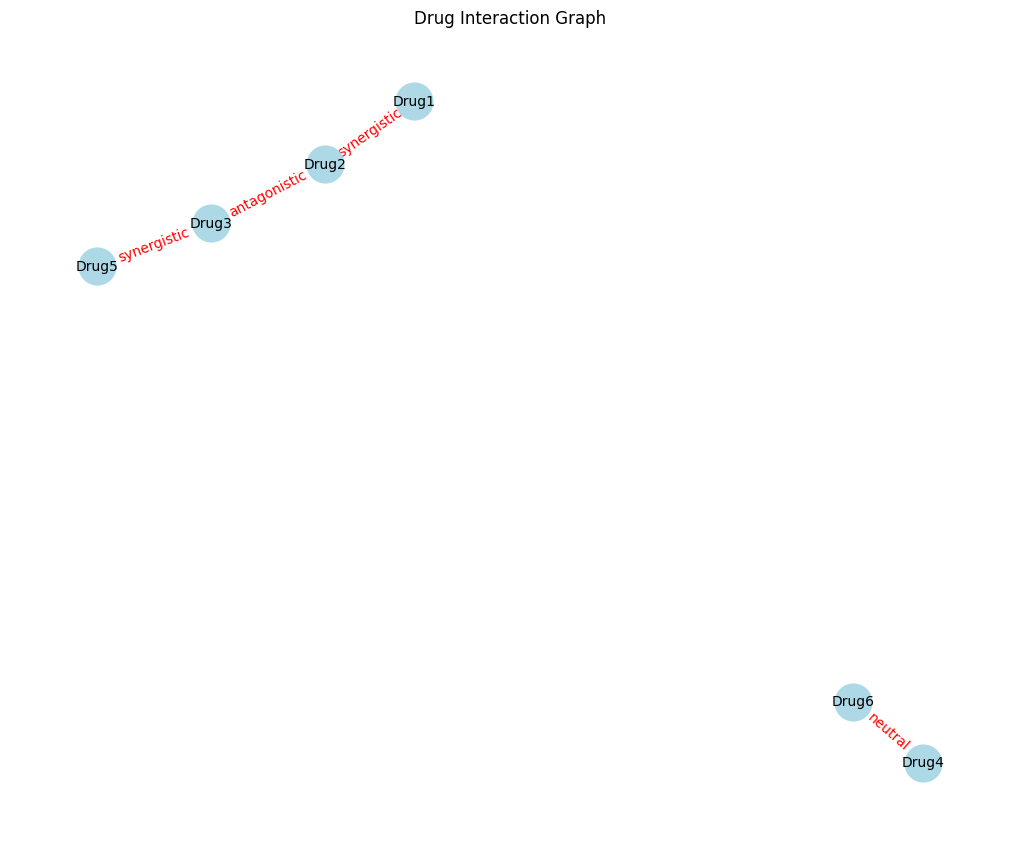

In [23]:
import matplotlib.pyplot as plt

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10)
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={(u, v): d['interaction'] for u, v, d in G.edges(data=True)}, font_color='red'
)
plt.title("Drug Interaction Graph")
plt.show()
